## Lossy image autoencoders with convolution and deconvolution networks in Tensorflow
Giuseppe Bonaccorso (https://www.bonaccorso.eu)

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [36]:
import multiprocessing
import tensorflow as tf

from numba import jit
from keras.datasets import cifar10
from skimage.color import rgb2gray

from sklearn.decomposition import PCA

In [6]:
# Set random seed (for reproducibility)
np.random.seed(1000)

In [17]:
width = 32
height = 32
batch_size = 10
nb_epochs = 15
code_length = 128

In [18]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [19]:
graph = tf.Graph()

with graph.as_default():
    # Global step
    global_step = tf.Variable(0, trainable=False)
    
    # Input batch
    input_images = tf.placeholder(tf.float32, shape=(batch_size, height, width, 3))

    # Convolutional layer 1
    conv1 = tf.layers.conv2d(inputs=input_images,
                             filters=32,
                             kernel_size=(3, 3),
                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                             activation=tf.nn.tanh)

    # Convolutional output (flattened)
    conv_output = tf.contrib.layers.flatten(conv1)

    # Code layer
    code_layer = tf.layers.dense(inputs=conv_output,
                                 units=code_length,
                                 activation=tf.nn.tanh)
    
    # Code output layer
    code_output = tf.layers.dense(inputs=code_layer,
                                  units=(height - 2) * (width - 2) * 3,
                                  activation=tf.nn.tanh)

    # Deconvolution input
    deconv_input = tf.reshape(code_output, (batch_size, height - 2, width - 2, 3))

    # Deconvolution layer 1
    deconv1 = tf.layers.conv2d_transpose(inputs=deconv_input,
                                         filters=3,
                                         kernel_size=(3, 3),
                                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                         activation=tf.sigmoid)
    
    # Output batch
    output_images = tf.cast(tf.reshape(deconv1, 
                                       (batch_size, height, width, 3)) * 255.0, tf.uint8)

    # Reconstruction L2 loss
    loss = tf.nn.l2_loss(input_images - deconv1)

    # Training operations
    learning_rate = tf.train.exponential_decay(learning_rate=0.0005, 
                                               global_step=global_step, 
                                               decay_steps=int(X_train.shape[0] / (2 * batch_size)), 
                                               decay_rate=0.95, 
                                               staircase=True)
    
    trainer = tf.train.RMSPropOptimizer(learning_rate)
    training_step = trainer.minimize(loss)

In [20]:
use_gpu = False

config = tf.ConfigProto(intra_op_parallelism_threads=multiprocessing.cpu_count(), 
                        inter_op_parallelism_threads=multiprocessing.cpu_count(), 
                        allow_soft_placement=True, 
                        device_count = {'CPU' : 1, 
                                        'GPU' : 1 if use_gpu else 0})

session = tf.InteractiveSession(graph=graph, config=config)

In [21]:
tf.global_variables_initializer().run()

In [22]:
@jit
def create_batch(t, gray=False):
    X = np.zeros((batch_size, height, width, 3 if not gray else 1), dtype=np.float32)
        
    for k, image in enumerate(X_train[t:t+batch_size]):
        if gray:
            X[k, :, :, :] = rgb2gray(image)
        else:
            X[k, :, :, :] = image / 255.0
        
    return X

In [23]:
for e in range(nb_epochs):
    total_loss = 0.0
    
    for t in range(0, X_train.shape[0], batch_size):
        feed_dict = {
            input_images: create_batch(t)
        }

        _, v_loss = session.run([training_step, loss], feed_dict=feed_dict)
        total_loss += v_loss
        
    print('Epoch {} - Total loss: {}'.format(e+1, total_loss))

Epoch 1 - Total loss: 964702.5862579346
Epoch 2 - Total loss: 642329.8581771851
Epoch 3 - Total loss: 626573.7311782837
Epoch 4 - Total loss: 620526.4181556702
Epoch 5 - Total loss: 617129.8573112488
Epoch 6 - Total loss: 613089.5037002563
Epoch 7 - Total loss: 610887.2535705566
Epoch 8 - Total loss: 605234.8465461731
Epoch 9 - Total loss: 605437.9782409668
Epoch 10 - Total loss: 602315.7485198975
Epoch 11 - Total loss: 601989.2040557861
Epoch 12 - Total loss: 597871.8482589722
Epoch 13 - Total loss: 600559.343711853
Epoch 14 - Total loss: 599234.5878639221
Epoch 15 - Total loss: 598892.4718513489


### Show some reconstructions

In [33]:
feed_dict = {
    input_images: create_batch(0)
}


oimages = session.run([output_images], feed_dict=feed_dict)

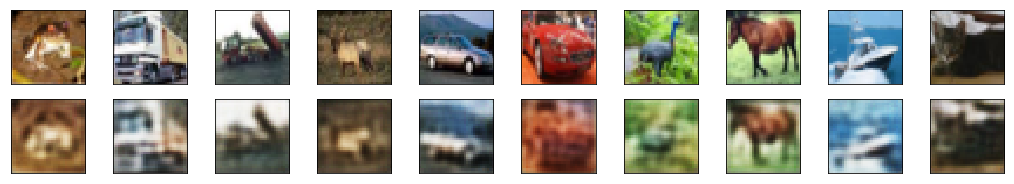

In [41]:
fig, ax = plt.subplots(2, batch_size, figsize=(18, 3))

for y in range(batch_size):
    ax[0, y].get_xaxis().set_visible(False)
    ax[0, y].get_yaxis().set_visible(False)
    ax[1, y].get_xaxis().set_visible(False)
    ax[1, y].get_yaxis().set_visible(False)

    ax[0, y].imshow(X_train[y])
    ax[1, y].imshow(oimages[0][y])